In [32]:
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torchlensmaker as tlm

from xxchallenge import *

base_height = 35


class Corners(nn.Module):
    def __init__(self, surface):
        super().__init__()
        self.surface = surface

    def forward(self, data):
        tf = data.tf()

        X = -1000
        WEIGHT = 1000

        corners = torch.tensor([
            [X, -500, -500],
            [X, 500, -500],
            [X, -500, 500],
            [X, 500, 500],
        ], dtype=torch.float64)

        # Transform corners to local frame
        Ps = tf.inverse_points(corners)

        F = self.surface.F(Ps) / 1000
        loss = WEIGHT * torch.clamp(F, max=0.0).pow(2).sum() / 4

        return data.replace(loss=data.loss + loss)


# Parameters
A = tlm.parameter(-1.14)
G0 = tlm.parameter(-255)

# XY polynomial parameters
C = tlm.parameter(torch.zeros((13,13), dtype=torch.float64))
fixed_mask = torch.zeros_like(C, dtype=torch.bool)
fixed_mask[0, 0] = True  # Freeze position (0,0)
C.register_hook(lambda grad: grad.masked_fill(fixed_mask, 0.))

cylinder = tlm.ImplicitCylinder(*torch.tensor([-50/2, 50/2, 37.02/2], dtype=torch.float64).unbind())
rod_data = StoreVar(lambda data: data)

# Primary mirror
sag = tlm.SagSum([
    tlm.Parabolic(A=A, normalize=True),
    tlm.XYPolynomial(C, normalize=True)
])
primary = tlm.SagSurface(1800, sag)
primary_data = StoreVar(lambda data: data)

# Optical model
optics = tlm.Sequential(
    tlm.Gap(-1000),
    XXLightSource.load(),

    # Primary mirror
    tlm.Gap(1000-base_height),
    primary_data,
    Corners(primary),
    tlm.ReflectiveSurface(primary),

    # Fixed rod
    tlm.AbsolutePosition(x=G0),
    #tlm.Rotate3D(y=45),
    rod_data,
    NonImagingRod(cylinder),
)

xxrender(optics, sampling={"xx": 500, "letter": "both"})

[  1/20] L= 0.55052 | grad norm= 2.01248894636375
[  2/20] L= 0.54763 | grad norm= 2.5310572369000717
[  3/20] L= 0.55837 | grad norm= 3.0547392341258006
[  4/20] L= 0.55512 | grad norm= 3.6856496885898298
[  5/20] L= 0.57567 | grad norm= 4.444892568404655
[  6/20] L= 0.59259 | grad norm= 5.554514423870172
[  7/20] L= 0.62469 | grad norm= 7.060169652508821
[  8/20] L= 0.69262 | grad norm= 8.891151333285066
[  9/20] L= 0.77001 | grad norm= 11.089923077021998
[ 10/20] L= 0.84563 | grad norm= 13.080499145633912
[ 11/20] L= 0.94123 | grad norm= 14.760980923844315
[ 12/20] L= 1.06248 | grad norm= 16.79416679775483
[ 13/20] L= 1.20805 | grad norm= 18.483747771223115
[ 14/20] L= 1.33713 | grad norm= 20.427787186887063
[ 15/20] L= 1.52392 | grad norm= 22.541401937058573
[ 16/20] L= 1.70047 | grad norm= 24.434750554218123
[ 17/20] L= 1.93509 | grad norm= 26.969327066926198
[ 18/20] L= 2.19040 | grad norm= 28.978653206468067
[ 19/20] L= 2.29806 | grad norm= 29.762951162832795
[ 20/20] L= 2.31305

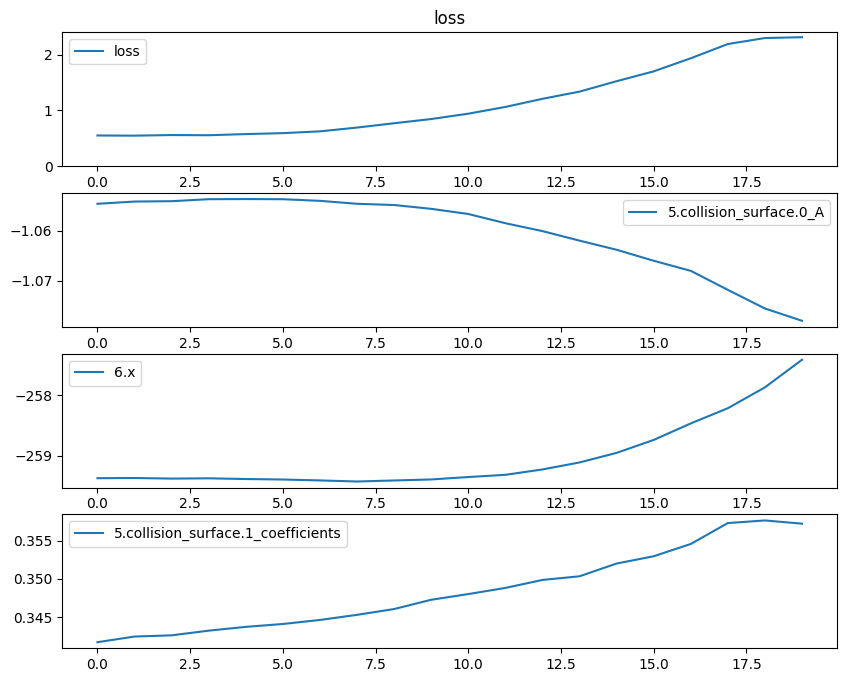

Best loss 0.5476281642913818 at iteration 2 / 20
    5.collision_surface.0_A tensor(-1.0542, dtype=torch.float64)
    5.collision_surface.1_coefficients tensor([[ 0.0000e+00,  2.6521e-04,  7.3677e-02, -1.6152e-03, -1.2067e-02,
          2.9853e-04, -5.9911e-02, -1.5815e-04, -4.7080e-02, -2.7545e-04,
         -2.5881e-02, -1.9675e-04, -1.2087e-02],
        [-9.1327e-03, -3.3939e-03, -8.9430e-04, -1.5518e-03,  5.6322e-04,
         -7.6548e-04,  1.3640e-03, -3.4275e-04,  9.0666e-04, -1.6829e-04,
          4.4330e-04, -8.0166e-05,  1.8983e-04],
        [ 6.9707e-02, -6.3591e-04, -1.7803e-02, -1.9178e-03, -1.2838e-02,
         -6.5870e-05, -1.3708e-02,  9.8402e-05, -8.9965e-03,  3.9151e-05,
         -4.6392e-03,  5.7885e-06, -2.0990e-03],
        [-1.7241e-03,  1.0174e-03,  5.1717e-03, -2.0726e-03,  2.5945e-03,
         -6.7467e-04,  1.2226e-03, -1.9880e-04,  5.1909e-04, -7.1833e-05,
          2.0436e-04, -3.0044e-05,  7.6806e-05],
        [-2.2223e-03,  7.8115e-05, -7.6560e-03, -5.4532e-04

In [38]:
param_groups = [
    {'params': [A], 'lr': 0.003},
    {'params': [G0], 'lr': 40},
    {'params': [C], 'lr': 0.008},
]


record = tlm.optimize(
    optics,
    optimizer = optim.SGD(param_groups),
    sampling = {"xx": 10000, "disable_viewer": True, "letter": "both"},
    dim = 3,
    num_iter = 20,
    nshow=20,
)

plot_record(record, param_groups, optics)
record.best()

print()
print("Final values")
print("A", A)
print("G0", G0)

# Print rod position
target = rod_data.value.target()
print("ROD X", target[1].item())
print("ROD Y", target[2].item())
print("ROD Z", -target[0].item())

xxrender(optics, sampling={"xx": 500, "letter": "both"})

In [23]:
# Print rod position
target = rod_data.value.target()
print("ROD POSITION IN XX FRAME")
print("ROD X", target[1].item())
print("ROD Y", target[2].item())
print("ROD Z", -target[0].item())
rod_z = f"z{-target[0].item():.0f}"
print(rod_z)

with torch.no_grad():
    part_primary = tess_mirror(xxgrid(499, 80), primary_data.value.tf(), primary)

part_sides = makesides(part_primary.vectors.dtype)

mesh.Mesh(np.concatenate([
    part_primary.data,
    part_sides.data
])).save(f"parabolaXY-{rod_z}.stl")



ROD POSITION IN XX FRAME
ROD X 0.0
ROD Y 0.0
ROD Z 213.64062139488826
z214
not in box tensor(0)
